In [1]:
import tensorflow as tf
import keras
from keras_vggface.vggface import VGGFace
import cv2
from matplotlib import pyplot as plt
import datetime

2023-09-12 20:38:21.678574: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 20:38:22.279925: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.config.list_physical_devices('GPU')

2023-09-12 20:38:29.030484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-12 20:38:29.054699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-12 20:38:29.054900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_dataset = keras.utils.image_dataset_from_directory('datasets_VGG',
                                                         validation_split = 0.1,
                                                         subset="training",
                                                         seed = 69420,
                                                         batch_size=16,
                                                         image_size=(224,224))

Found 1792 files belonging to 4 classes.
Using 1613 files for training.


2023-09-12 20:38:37.541141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-12 20:38:37.541317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-12 20:38:37.541423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
valid_dataset = keras.utils.image_dataset_from_directory('datasets_VGG',
                                                         validation_split = 0.1,
                                                         subset="validation",
                                                         seed = 69420,
                                                         batch_size=16,
                                                         image_size=(224,224))

Found 1792 files belonging to 4 classes.
Using 179 files for validation.


In [5]:
data_aug = keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

In [6]:
vggface_resnet_base = VGGFace(model='resnet50')

In [7]:
print('Inputs: %s' % vggface_resnet_base.inputs)
print('Outputs: %s' % vggface_resnet_base.outputs)

Inputs: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>]
Outputs: [<KerasTensor: shape=(None, 8631) dtype=float32 (created by layer 'classifier')>]


In [8]:
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace

In [9]:
number_class = 4

In [10]:
vggface_resnet_base.trainable = False
last_layer = vggface_resnet_base.get_layer('avg_pool').output

inputs = tf.keras.Input(shape=(224,224,3))

x = data_aug(inputs)
x = vggface_resnet_base(x)
x = Flatten(name='flatten')(x)

out = Dense(4, name='classifier')(x)
custom_model = keras.Model(inputs, out)

In [11]:
base_lr = 0.0005

custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
                     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

In [12]:
custom_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vggface_resnet50 (Functiona  (None, 8631)             41246071  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 8631)              0         
                                                                 
 classifier (Dense)          (None, 4)                 34528     
                                                                 
Total params: 41,280,599
Trainable params: 34,528
Non-trainable params: 41,246,071
____________________________________________

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                  patience=5)

In [14]:
his = custom_model.fit(train_dataset, validation_data=valid_dataset, 
                       epochs=300, callbacks=[early_stopping])

Epoch 1/300


2023-09-12 20:38:40.082405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1613]
	 [[{{node Placeholder/_4}}]]
2023-09-12 20:38:40.082695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1613]
	 [[{{node Placeholder/_4}}]]
2023-09-12 20:38:43.609948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-09-12 20:38:44.912491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-12 20

  3/101 [..............................] - ETA: 3s - loss: 1.3852 - accuracy: 0.3958  

2023-09-12 20:38:45.753954: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


101/101 [==============================] - ETA: 0s - loss: 1.3715 - accuracy: 0.4265

2023-09-12 20:38:50.421212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [179]
	 [[{{node Placeholder/_4}}]]
2023-09-12 20:38:50.421437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [179]
	 [[{{node Placeholder/_4}}]]


101/101 [==============================] - 12s 59ms/step - loss: 1.3715 - accuracy: 0.4265 - val_loss: 1.3488 - val_accuracy: 0.4302
Epoch 2/300
101/101 [==============================] - 4s 43ms/step - loss: 1.3469 - accuracy: 0.4216 - val_loss: 1.3186 - val_accuracy: 0.4246
Epoch 3/300
101/101 [==============================] - 4s 43ms/step - loss: 1.3249 - accuracy: 0.4141 - val_loss: 1.2902 - val_accuracy: 0.4190
Epoch 4/300
101/101 [==============================] - 4s 43ms/step - loss: 1.3063 - accuracy: 0.4160 - val_loss: 1.2640 - val_accuracy: 0.4190
Epoch 5/300
101/101 [==============================] - 4s 43ms/step - loss: 1.2870 - accuracy: 0.4160 - val_loss: 1.2389 - val_accuracy: 0.4246
Epoch 6/300
101/101 [==============================] - 4s 43ms/step - loss: 1.2707 - accuracy: 0.4172 - val_loss: 1.2154 - val_accuracy: 0.4302
Epoch 7/300
101/101 [==============================] - 4s 43ms/step - loss: 1.2554 - accuracy: 0.4191 - val_loss: 1.1935 - val_accuracy: 0.4302
Epo

Text(0, 0.5, 'Loss')

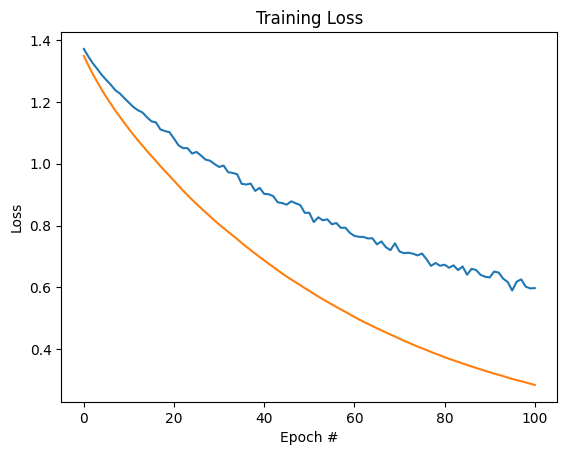

In [15]:
plt.figure()
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

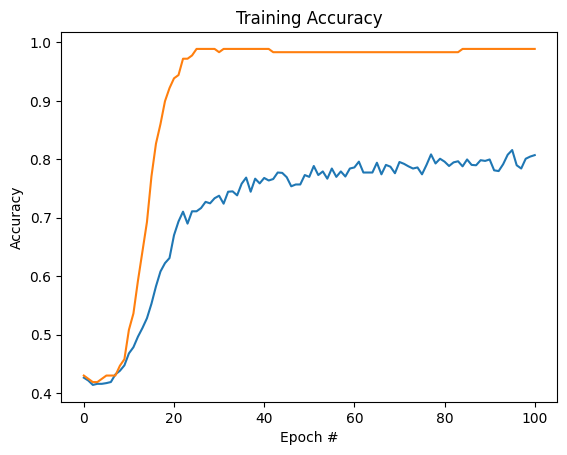

In [16]:
plt.figure()
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')

In [17]:
prob_model = keras.Sequential([custom_model,
                               tf.keras.layers.Softmax()
                               ])

In [20]:
time_stamp = datetime.datetime.now()
time_stamp.strftime("%d_%b_%y_%H_%M_%S")
prob_model.save(f"model/model_{time_stamp}.tf")

2023-09-12 20:47:52.156776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [?,224,224,3]
	 [[{{node random_flip_input}}]]
2023-09-12 20:47:52.243848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,224,224,3]
	 [[{{node inputs}}]]
2023-09-12 20:47:52.253926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [

INFO:tensorflow:Assets written to: model/model_2023-09-12 20:47:51.773800.tf/assets


INFO:tensorflow:Assets written to: model/model_2023-09-12 20:47:51.773800.tf/assets
